In [1]:
!pip install transformers

  Using cached transformers-4.44.2-py3-none-any.whl.metadata (43 kB)
Using cached transformers-4.44.2-py3-none-any.whl (9.5 MB)
   ---------------------------------------- 0.0/286.2 kB ? eta -:--:--
   ---------------------------------- ----- 245.8/286.2 kB 7.4 MB/s eta 0:00:01
   ---------------------------------------- 286.2/286.2 kB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------- ----------------------- 0.9/2.2 MB 19.0 MB/s eta 0:00:01
   ---------------------------------------  2.2/2.2 MB 28.2 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 23.5 MB/s eta 0:00:00


In [7]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.2.2+cu121 (NVIDIA GeForce RTX 4070)


In [8]:
import json

# Function to convert image IDs from string to integer
def convert_image_id_to_int(file_path, output_file):
    # Load the JSON file
    with open(file_path, "r") as file:
        data = json.load(file)
    
    # Convert image IDs in the 'images' section
    for image in data['images']:
        image['id'] = int(image['id'].replace("train_", "").replace("val_", ""))  # Convert to int, removing any prefix

    # Convert image IDs in the 'annotations' section
    for annotation in data['annotations']:
        annotation['image_id'] = int(annotation['image_id'].replace("train_", "").replace("val_", ""))  # Convert to int

    # Save the modified JSON to a new file
    with open(output_file, "w") as output:
        json.dump(data, output, indent=4)

    print(f"Image IDs in '{file_path}' have been converted and saved to '{output_file}'.")

# File paths for train and val datasets
train_file_path = "C:/Users/kimin/HSC_dataset/provided_dataset/train/train.json"  # Change to your actual path if needed
val_file_path = "C:/Users/kimin/HSC_dataset/provided_dataset/val/val.json"  # Already uploaded

# Output files for modified datasets
train_output_file = "train_int.json"
val_output_file = "val_int.json"

# Convert image IDs for both datasets
convert_image_id_to_int(train_file_path, train_output_file)
convert_image_id_to_int(val_file_path, val_output_file)

Image IDs in 'C:/Users/kimin/HSC/YOLOS/dataset/train/train.json' have been converted and saved to 'train_int.json'.
Image IDs in 'C:/Users/kimin/HSC/YOLOS/dataset/valid/val.json' have been converted and saved to 'val_int.json'.


## Convert COCO format to YOLOS
#### COCO json 형식을 YOLOS에 맞게 변환

In [1]:
#Register dataset as torchvision CocoDetection
import torchvision
import os
from transformers import AutoFeatureExtractor

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file_name, train=True):
        ann_file = os.path.join(img_folder, ann_file_name)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target
    
# 로컬 데이터셋 경로 설정
local_dataset_path = "C:/Users/kimin/HSC_dataset/provided_dataset/"  # 로컬 데이터셋의 경로

feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=640)

# 학습 및 검증 데이터셋 로드 (주석 파일 이름을 실제 파일명으로 변경)
train_dataset = CocoDetection(
    img_folder=os.path.join(local_dataset_path, 'train/images'), 
    feature_extractor=feature_extractor, 
    ann_file_name='train_int.json'  # 실제 파일 이름을 사용
)

val_dataset = CocoDetection(
    img_folder=os.path.join(local_dataset_path, 'val/images'), 
    feature_extractor=feature_extractor, 
    ann_file_name='val_int.json',  # 검증 데이터도 주석 파일 이름을 맞춤
    train=False
)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

c:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Number of training examples: 7018
Number of validation examples: 600


In [2]:
#Setup dataloader for training loop

from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=32)
batch = next(iter(train_dataloader))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [4]:
# id2label 정의
cats = train_dataset.coco.cats  # COCO 카테고리 정보 가져오기
print(cats)
id2label = {k: v['name'] for k, v in cats.items()}  # id -> label 딕셔너리 생성
print(id2label)

{0: {'supercategroy': 'person', 'id': 0, 'name': 'person'}, 1: {'supercategroy': 'vehicle', 'id': 1, 'name': 'car'}, 2: {'supercategroy': 'vehicle', 'id': 2, 'name': 'truck'}, 3: {'supercategroy': 'vehicle', 'id': 3, 'name': 'bus'}, 4: {'supercategroy': 'vehicle', 'id': 4, 'name': 'bicycle'}, 5: {'supercategroy': 'vehicle', 'id': 5, 'name': 'bike'}, 6: {'supercategroy': 'vehicle', 'id': 6, 'name': 'extra_vehicle'}, 7: {'supercategroy': 'animal', 'id': 7, 'name': 'dog'}}
{0: 'person', 1: 'car', 2: 'truck', 3: 'bus', 4: 'bicycle', 5: 'bike', 6: 'extra_vehicle', 7: 'dog'}


In [5]:
# For our training configuration, we will start from the pretrained YOLOS-tiny model from 
# Hugging Face transformers

import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection
import torch

#we wrap our model around pytorch lightning for training
class YoloS(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.weight_decay = weight_decay
         self.save_hyperparameters()  # adding this will save the hyperparameters to W&B too

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("train/loss", loss)  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("train/" + k, v.item())  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss) # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("validation/" + k, v.item()) #  logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [6]:
#initialize the model
model = YoloS(lr=5e-5, weight_decay=1e-5)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([9, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Name your wandb project and upload the final checkpoint to wandb, according to ModelCheckpoint
# Click on the output wandb run name below to see your metrics updating live in wandb
wandb_logger = WandbLogger(project='IR detection-yolos', log_model=True)

# Keep track of the checkpoint with the lowest validation loss
# 여러 조건에 따른 체크포인트 저장
checkpoint_callback = ModelCheckpoint(
    monitor='validation/loss',  # validation loss를 기준으로
    mode='min',  # 손실이 가장 낮을 때 저장
    save_top_k=3,  # 성능이 가장 좋은 3개의 체크포인트 저장
    save_last=True,  # 마지막 체크포인트 저장
    filename='{epoch:02d}-{val_loss:.2f}',  # 파일 이름에 에포크와 검증 손실 포함
    dirpath='C:/Users/kimin/HSC/YOLOS/checkpoints'  # 체크포인트 저장 경로
)

In [7]:
from pytorch_lightning import Trainer

#more epochs leads to a tighter fit of your model to your data.
#we set epochs=10 here for an example of quick training
trainer = Trainer(
    accelerator='gpu', 
    devices=1, 
    max_epochs=50, 
    gradient_clip_val=0.1, 
    accumulate_grad_batches=8, 
    log_every_n_steps=5, 
    logger=wandb_logger, 
    callbacks=[checkpoint_callback]
    )

trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wasd3691 (wasd3691-seoul-national-university-ofscience-and-technology). Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params | Mode
---------------------------------------------------------
0 | model | YolosForObjectDetection | 6.5 M  | eval
---------------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.891    Total estimated model params size (MB)
0         Modules in train mode
236       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\transformers\models\yolos\modeling_yolos.py:324: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
c:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\U

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [9]:
#clean up torch tensors before eval so your gpu memory doesn't crash!
torch.cuda.empty_cache()

In [10]:
#we borrow the eval scripts from the DETR repo as they provide similar functionality to what we need to calculate mAP
#!git clone https://github.com/facebookresearch/detr.git
%cd C:/Users/kimin/HSC/detr

C:\Users\kimin\HSC\detr


In [11]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset) # this is actually just calling the coco attribute

In [14]:
!pip install ipywidgets

   ---------------------------------------- 0.0/139.8 kB ? eta -:--:--
   -- ------------------------------------- 10.2/139.8 kB ? eta -:--:--
   -------- ------------------------------ 30.7/139.8 kB 262.6 kB/s eta 0:00:01
   -------- ------------------------------ 30.7/139.8 kB 262.6 kB/s eta 0:00:01
   ----------------- --------------------- 61.4/139.8 kB 273.8 kB/s eta 0:00:01
   ------------------------- ------------- 92.2/139.8 kB 350.1 kB/s eta 0:00:01
   ------------------------------ ------- 112.6/139.8 kB 409.6 kB/s eta 0:00:01
   -------------------------------------- 139.8/139.8 kB 394.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/214.4 kB ? eta -:--:--
   ----------------- ---------------------- 92.2/214.4 kB 1.7 MB/s eta 0:00:01
   -------------------------------- ------- 174.1/214.4 kB 2.1 MB/s eta 0:00:01
   -------------------------------- ------- 174.1/214.4 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 214.4/214.4 kB 1.2 MB/s

In [12]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Running evaluation...


  0%|          | 0/19 [00:00<?, ?it/s]

c:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\transformers\models\yolos\modeling_yolos.py:324: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
`post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.


Accumulating evaluation results...
DONE (t=0.52s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [13]:
# 학습된 모델을 체크포인트에서 로드
trained_model = YoloS.load_from_checkpoint("C:/Users/kimin/HSC/YOLOS/checkpoints/epoch=40-val_loss=0.00.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 GPU로 이동
trained_model.to(device)
trained_model.model.to(device)  # 내부 모델도 GPU로 전송 (필요한 경우)

trained_model.eval()  # 평가 모드로 전환

from datasets.coco_eval import CocoEvaluator
from tqdm import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths


print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = trained_model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()
#the evaluation here prints out mean average precision details
#learn more - https://blog.roboflow.com/mean-average-precision/

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([9, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


100%|██████████| 19/19 [02:16<00:00,  7.17s/it]


Accumulating evaluation results...
DONE (t=0.51s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [20]:
#We can use the image_id in target to know which image it is

pixel_values, target = val_dataset[7]
pixel_values = pixel_values.unsqueeze(0).to(device)
outputs = model(pixel_values=pixel_values)

In [21]:
import torch
import matplotlib.pyplot as plt

#lower confidence yields more, but less accurate predictions
CONFIDENCE=0.2

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=CONFIDENCE):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [22]:
# MORGAN
def log_image_bboxes_to_wandb(image, outputs, image_name='my_image', threshold=CONFIDENCE):
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  box_data = []
  for p,bbox in zip(probas, bboxes_scaled):
    position = dict(
                minX=int(bbox[0]),
                minY=int(bbox[1]),
                maxX=int(bbox[2]),
                maxY=int(bbox[3])
                )
    cl = int(p.argmax().cpu().detach().item())
    scores = {"loss": p[cl].cpu().detach().item()}

    box_data.append({
                'position': position,
                'class_id': cl,
                'scores' : scores,
                'domain': 'pixel'
            })

  wandb_bbox_dict = {
              'box_data': box_data,
              'class_labels': id2label
          }
  wandb_boxes = {}
  wandb_boxes['predictions'] = wandb_bbox_dict

  # Log the image with bounding boxes to wandb
  img = wandb.Image(image, boxes=wandb_boxes)
  wandb.log({image_name:img})
  print('Image with bounding boxes logged to your wandb run!')

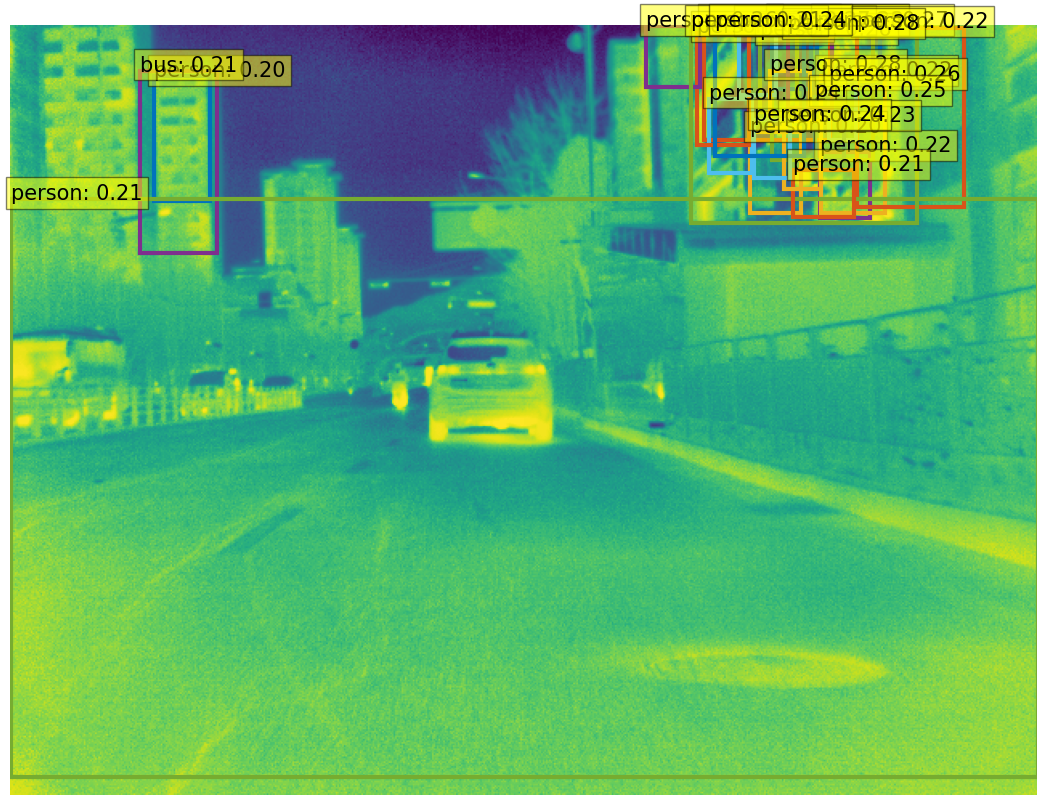

In [23]:
from PIL import Image  # Image 모듈을 PIL에서 임포트
import os  # os 모듈을 임포트하여 경로 처리를 함

image_dir = "C:/Users/kimin/HSC/dataset/val/images"
image_id = target['image_id'].item()
image_info = val_dataset.coco.loadImgs(image_id)[0]

image = Image.open(os.path.join(image_dir, image_info['file_name']))

visualize_predictions(image, outputs)